In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('./data_scrap/data.csv')

In [2]:
# function with the help of chatGPT

def scrollable_dataframe(df):
    # Konwertuj DataFrame na tabelę HTML
    table_html = df.to_html(classes='table table-striped table-bordered table-hover',
                            table_id='scrollable_table', 
                            escape=False)

    # Tworzenie kodu HTML dla scrollowanej tabeli
    html = f'''
    <div style="width: 100%; height:400px; overflow:scroll;">
            <style>
             td, th {{
                white-space: nowrap;
                width: 100px;
                padding: 10px;
            }}
        </style>
        {table_html}
    </div>
    '''

    return html

In [3]:
from IPython.display import display, HTML
display(HTML(scrollable_dataframe(data.head(10))))

,team_1st,team_2nd,score_1st,score_2nd,possession_1st,possession_2nd,shots_1st,shots_2nd,shots_on_target_1st,shots_on_target_2nd,corners_1st,corners_2nd,passes_1st,passes_2nd,accurate_passes_1st,accurate_passes_2nd,crosses_1st,crosses_2nd,accurate_crosses_1st,accurate_crosses_2nd,successful_tackles_1st,successful_tackles_2nd,fouls_1st,fouls_2nd,offsides_1st,offsides_2nd,yellow_cards_1st,yellow_cards_2nd,red_cards_1st,red_cards_2nd
0,GÓRNIK ŁĘCZNA,JAGIELLONIA BIAŁYSTOK,0,1,47.0,53.0,10.0,14.0,2.0,4.0,4.0,5.0,389.0,447.0,321.0,374.0,25.0,24.0,8.0,2.0,9.0,10.0,20.0,12.0,0.0,2.0,4.0,3.0,0.0,0.0
1,ŚLĄSK WROCŁAW,GÓRNIK ZABRZE,3,4,51.0,49.0,20.0,12.0,8.0,6.0,9.0,2.0,447.0,452.0,376.0,373.0,26.0,9.0,6.0,2.0,7.0,12.0,7.0,7.0,2.0,1.0,1.0,0.0,0.0,0.0
2,LECH POZNAŃ,KGHM ZAGŁĘBIE LUBIN,2,1,56.0,44.0,21.0,15.0,9.0,6.0,4.0,7.0,457.0,353.0,372.0,257.0,17.0,19.0,6.0,8.0,5.0,8.0,9.0,13.0,0.0,2.0,1.0,2.0,0.0,0.0
3,PIAST GLIWICE,RADOMIAK RADOM,1,1,51.0,49.0,14.0,10.0,3.0,2.0,7.0,3.0,445.0,434.0,364.0,372.0,27.0,10.0,6.0,1.0,12.0,11.0,10.0,20.0,1.0,2.0,1.0,2.0,0.0,0.0
4,WISŁA KRAKÓW,WARTA POZNAŃ,0,1,54.0,46.0,18.0,4.0,5.0,2.0,7.0,3.0,411.0,368.0,333.0,287.0,28.0,5.0,11.0,0.0,4.0,11.0,19.0,11.0,0.0,1.0,2.0,2.0,0.0,0.0
5,POGOŃ SZCZECIN,BRUK-BET TERMALICA NIECIECZA,2,2,54.0,46.0,21.0,13.0,6.0,4.0,8.0,8.0,445.0,374.0,359.0,298.0,22.0,18.0,8.0,4.0,14.0,8.0,10.0,10.0,1.0,2.0,2.0,3.0,0.0,0.0
6,RAKÓW CZĘSTOCHOWA,LECHIA GDAŃSK,3,0,49.0,51.0,18.0,7.0,9.0,3.0,6.0,1.0,426.0,448.0,332.0,349.0,14.0,8.0,3.0,1.0,10.0,5.0,14.0,16.0,3.0,0.0,1.0,4.0,0.0,0.0
7,LEGIA WARSZAWA,CRACOVIA,3,0,51.0,49.0,12.0,15.0,4.0,2.0,4.0,7.0,432.0,408.0,347.0,330.0,16.0,20.0,8.0,6.0,13.0,11.0,16.0,11.0,1.0,3.0,2.0,0.0,0.0,0.0
8,WISŁA PŁOCK,PGE FKS STAL MIELEC,3,0,56.0,44.0,18.0,14.0,10.0,2.0,11.0,3.0,429.0,340.0,345.0,269.0,27.0,14.0,6.0,1.0,8.0,12.0,10.0,13.0,2.0,0.0,3.0,1.0,0.0,0.0
9,CRACOVIA,WISŁA PŁOCK,3,0,54.0,46.0,27.0,5.0,6.0,0.0,7.0,5.0,423.0,370.0,351.0,285.0,26.0,17.0,6.0,3.0,16.0,9.0,11.0,10.0,1.0,1.0,1.0,1.0,0.0,0.0


In [4]:
len(data)

306

In [5]:
data.isna().sum()

team_1st                    0
team_2nd                    0
score_1st                   0
score_2nd                   0
possession_1st             14
possession_2nd             14
shots_1st                  14
shots_2nd                  14
shots_on_target_1st        14
shots_on_target_2nd        14
corners_1st                14
corners_2nd                14
passes_1st                 14
passes_2nd                 14
accurate_passes_1st        14
accurate_passes_2nd        14
crosses_1st                14
crosses_2nd                14
accurate_crosses_1st       14
accurate_crosses_2nd       14
successful_tackles_1st     14
successful_tackles_2nd     14
fouls_1st                  14
fouls_2nd                  14
offsides_1st               14
offsides_2nd               14
yellow_cards_1st          216
yellow_cards_2nd          216
red_cards_1st             216
red_cards_2nd             216
dtype: int64

Something wrong happened to cards...

In [6]:
numeric_cols = data.columns.to_list()
numeric_cols.remove('team_1st')
numeric_cols.remove('team_2nd')


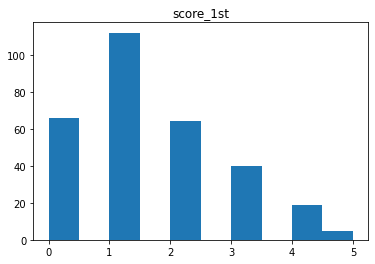

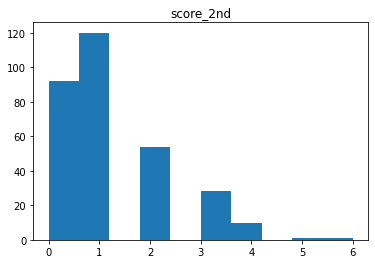

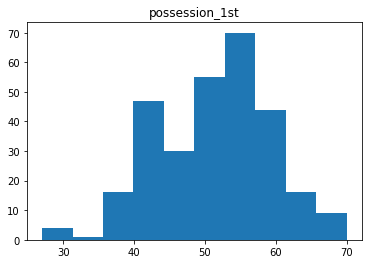

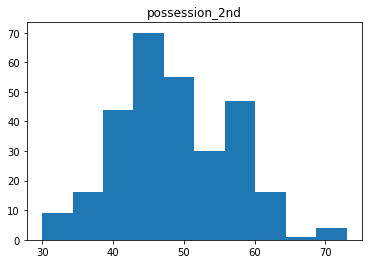

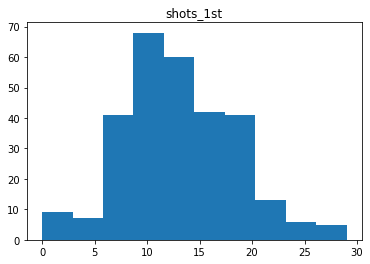

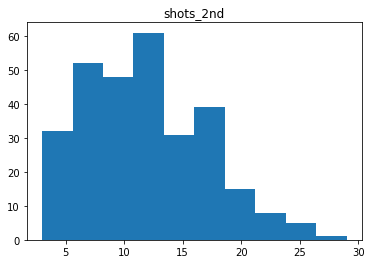

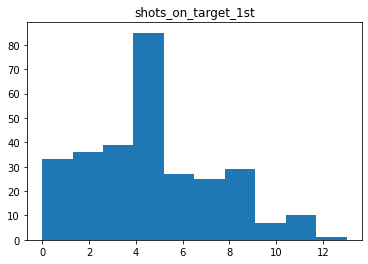

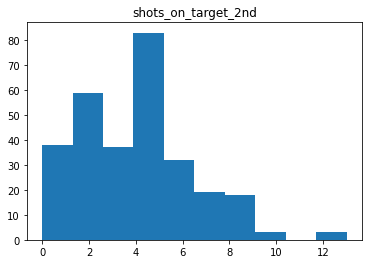

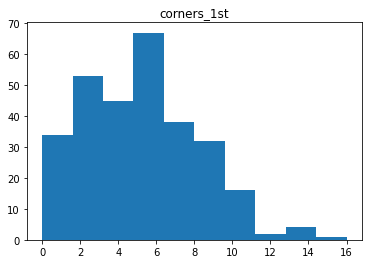

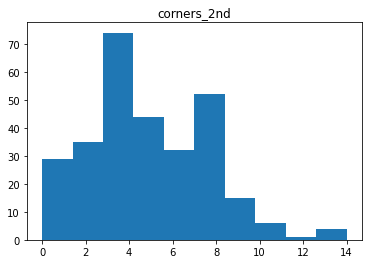

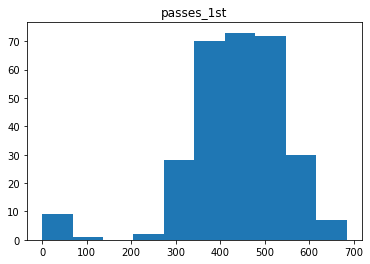

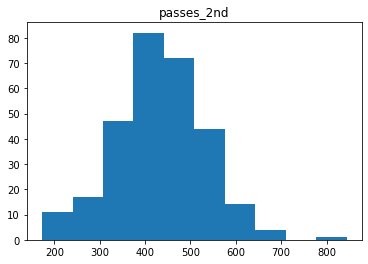

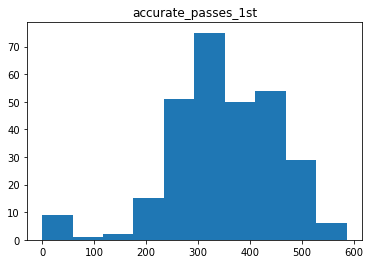

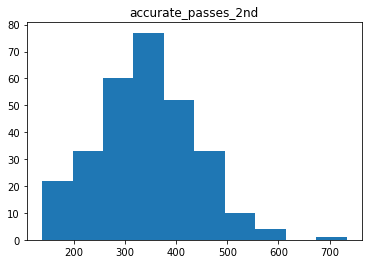

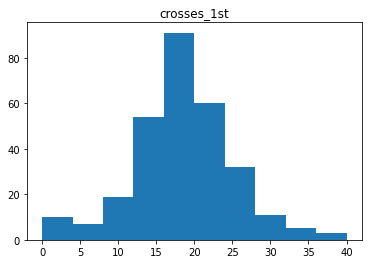

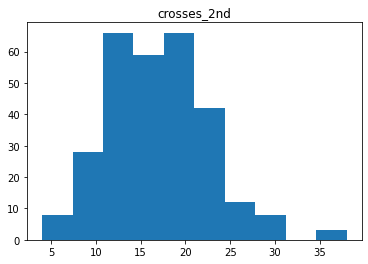

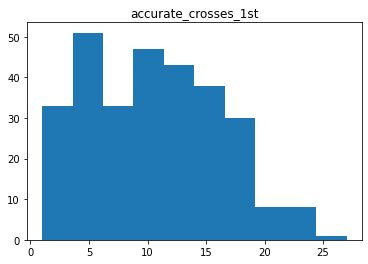

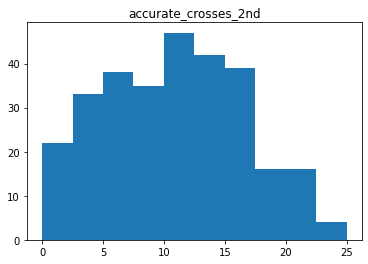

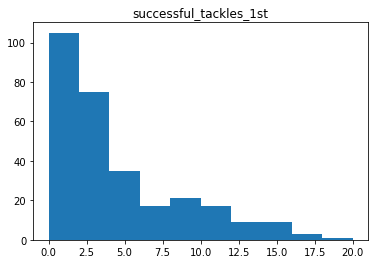

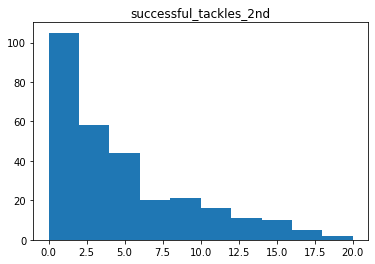

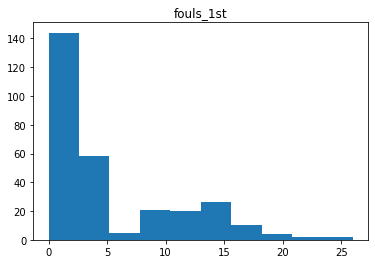

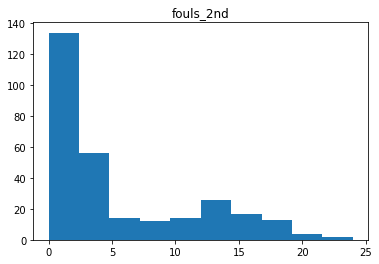

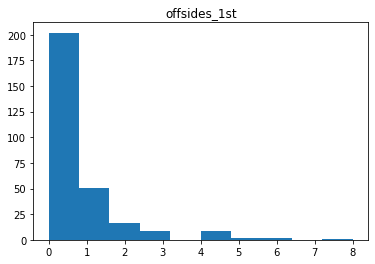

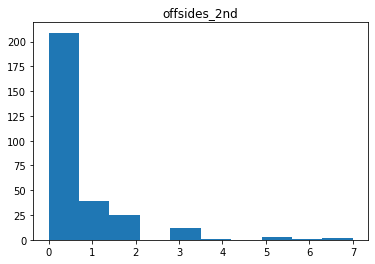

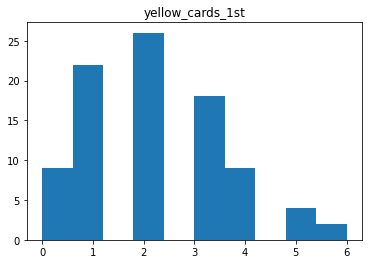

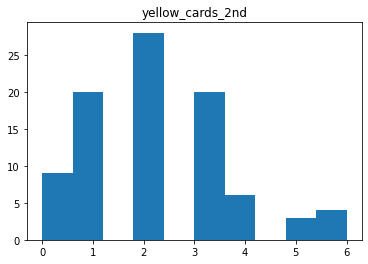

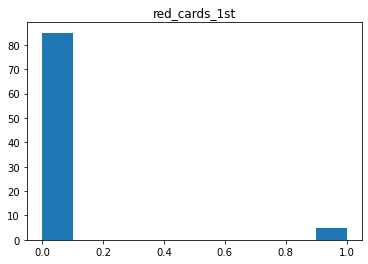

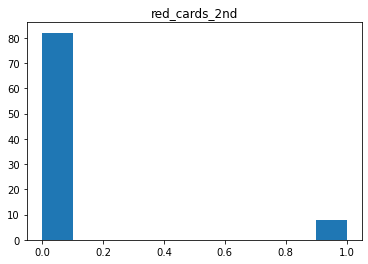

In [7]:
import matplotlib.pyplot as plt

for col_name in numeric_cols:
    plt.hist(data[col_name].dropna().astype(int))
    plt.title(col_name)
    plt.show()
    

### Does Goals follow Poission distribution?

## Examples of density plots of Poisson distributions:

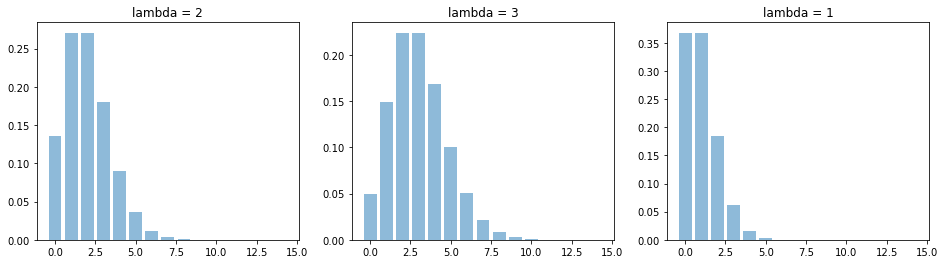

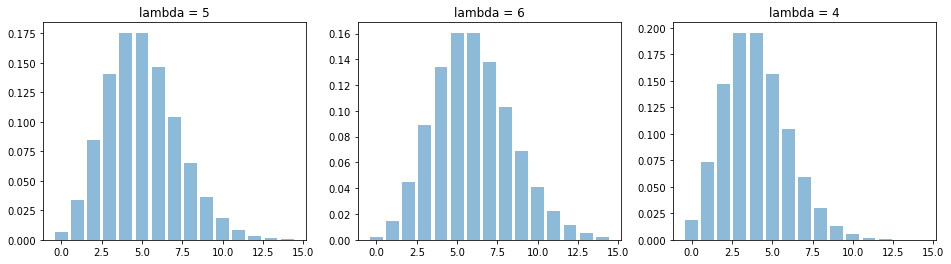

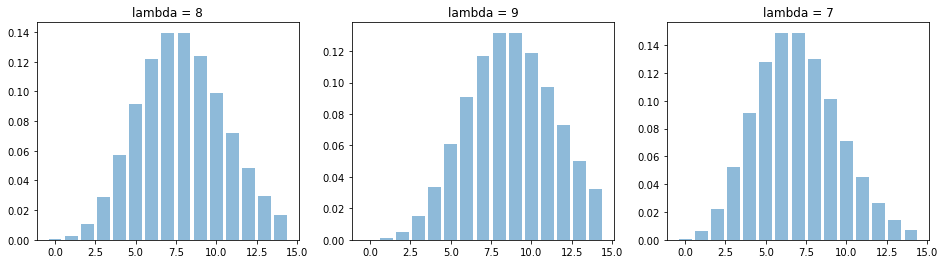

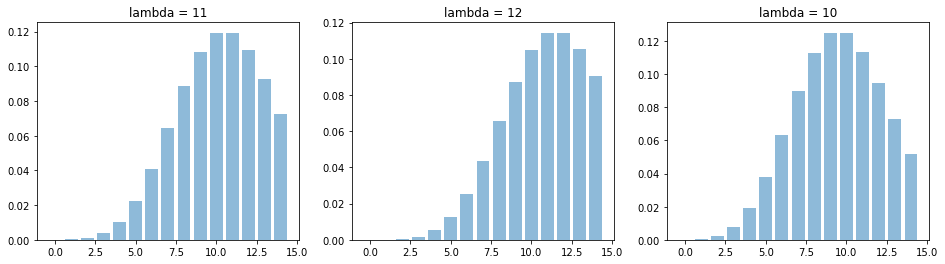

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

for i in range(1, 13):
    if i % 3 == 1: plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, ((i + 1) % 3) + 1 )
    x = np.arange(0, 15)
    plt.bar(x, poisson.pmf(x, i), align='center', alpha=0.5, label='Poisson PMF')
    plt.title(f'lambda = {i}')
    if i % 3 == 0: plt.show()

    

### To check this, i will take 'observed' and 'expected' values from given observations (assuming that it follows Pois distribution) to calculate chi_squared statistic present in test where:
### the null Hypothesis says that the data follows Poisson distribution vs the alternative: it does not .

In [9]:
from scipy.stats import poisson
from typing import List

# the function below split data into bins to calculate chi squared statistic to check consistency with Pois distribution
def buildBinsForPoisson(vals: pd.Series) -> (List[int], List[int]):
    prevent_push = False
    vals = vals.sort_index()
    indices = vals.index
    values = vals.values
    total = np.sum(values)
    no_index = len(indices)
    curr_index = no_index - 1
    estimated_lambda = 0
    for i in indices:
        estimated_lambda += i*vals[i]
    estimated_lambda = estimated_lambda / total
    observed = []
    expected = []
    while(curr_index >= 0):
        expected_value = 0
        observed_value = 0
        while expected_value < 5:
            prob_of_value = 0
            if curr_index == no_index - 1:
                prob_of_value = 1 - poisson.cdf(indices[curr_index] - 1, estimated_lambda)
            else:
                prob_of_value = poisson.pmf(indices[curr_index], estimated_lambda)
                
            expected_value += prob_of_value*total
            observed_value += vals[indices[curr_index]]
            curr_index = curr_index - 1
            if curr_index == -1 and expected_value < 5:
                observed[-1] += observed_value
                expected[-1] += expected_value
                prevent_push = True
                break
                
        if not prevent_push:
            observed.append(observed_value)
            expected.append(expected_value)
    observed.reverse()
    expected.reverse()
    return (observed, expected)

In [10]:
from scipy.stats import poisson
from scipy.stats import chisquare

# testing our function on sample from Poiss
pois_sample = poisson.rvs(3, size=100, random_state=17)
sample_series = pd.Series(pois_sample).value_counts()
(observed, expected) = buildBinsForPoisson(sample_series)
chisquare(observed, expected)


Power_divergenceResult(statistic=0.21505517023764972, pvalue=0.9989432266515322)

### pvalue ~ 0.99 ensures us that the sample is from Poisson distribution (so the function probably works) 

In [11]:
from scipy.stats import chisquare

values = data['score_1st'].value_counts()
(observed, expected) = buildBinsForPoisson(values)
chisquare(observed, expected)


Power_divergenceResult(statistic=4.684798911190217, pvalue=0.4555448464103339)

### Let significance level be 0.05. By receiving pvalue ~ 0.45, there is no basis to reject the null hypothesis saying that 'score_1st' (distribution of goals scored by hosts of all matches) follows Poission distribution. Given that, i say that more probably than not 'score_1st' follows Poission distribution

### I will also check "poissonabality" of some other data variables

In [12]:
def getChiSquareResult(df: pd.DataFrame):
    (obs, exp) = buildBinsForPoisson(df.value_counts())
    return chisquare(obs, exp)

In [17]:
# the lack of data is frequent so we filter by any column which has missing values
data_f = data.copy()[~data['possession_1st'].isna()]

data_f['score_total'] = data_f['score_1st'] + data_f['score_2nd']
data_f['shots_total'] = data_f['shots_1st'] + data_f['shots_2nd']
data_f['shots_on_target_total'] = data['shots_1st'] + data['shots_2nd']
data_f['corners_total'] = data_f['corners_1st'] + data_f['corners_2nd']
data_f['fouls_total'] = data_f['fouls_1st'] + data_f['fouls_2nd']
data_f['passes_total'] = data_f['passes_1st'] + data_f['passes_2nd']
data_f['accurate_passes_total'] = data_f['accurate_passes_1st'] + data_f['accurate_passes_2nd']
data_f['crosses_total'] = data_f['crosses_1st'] + data_f['crosses_2nd']
data_f['accurate_crosses_total'] = data_f['accurate_crosses_1st'] + data_f['accurate_crosses_2nd']
data_f['successful_tackles_total'] = data_f['successful_tackles_1st'] + data_f['successful_tackles_2nd']
data_f['offsides_total'] = data_f['offsides_1st'] + data_f['offsides_2nd']
data_f['yellow_cards_total'] = data['yellow_cards_1st'] + data['yellow_cards_2nd']


In [19]:
cols = ['score_total', 'shots_total', 'shots_on_target_total', 'corners_total', 'fouls_total', 'passes_total', 'accurate_passes_total', 'crosses_total', 'accurate_crosses_total', 'successful_tackles_total', 'offsides_total', 'yellow_cards_total']

print("BEING FROM POISION DISTRIBUTION")
print('-------------------')
for col in cols:
    print('**********')
    print(col, 'p-value: ', getChiSquareResult(data_f[col]).pvalue)

BEING FROM POISION DISTRIBUTION
-------------------
**********
score_total p-value:  0.9893101458616
**********
shots_total p-value:  1.5511762443254247e-07
**********
shots_on_target_total p-value:  1.5511762443254247e-07
**********
corners_total p-value:  6.274580998860991e-06
**********
fouls_total p-value:  0.0
**********
passes_total p-value:  0.0
**********
accurate_passes_total p-value:  0.0
**********
crosses_total p-value:  2.4008714604150212e-17
**********
accurate_crosses_total p-value:  1.56140374367165e-286
**********
successful_tackles_total p-value:  0.0
**********
offsides_total p-value:  8.304415068142364e-53
**********
yellow_cards_total p-value:  0.4588768108920125


### Apart from goals (looking at p-value of the test) only 'yellow_cards' seems to follow Poisson distribution.

### How about normality of some of the columns?

In [32]:
from scipy.stats import shapiro

cols_to_check_normality = ['shots_total', 'shots_on_target_total', 'corners_total', 'passes_total', 'crosses_total', 'accurate_crosses_total']

print("BEING FROM NORMAL DISTRIBUTION")
print('-------------------')
for col in cols_to_check_normality:
    print('**********')
    print(col, 'p-value: ', shapiro(data_f[col]).pvalue)

BEING FROM NORMAL DISTRIBUTION
-------------------
**********
shots_total p-value:  3.792218805642733e-08
**********
shots_on_target_total p-value:  3.792218805642733e-08
**********
corners_total p-value:  0.0014619276626035571
**********
passes_total p-value:  8.38893942391176e-20
**********
crosses_total p-value:  1.5469331628992222e-06
**********
accurate_crosses_total p-value:  8.078522739651817e-09


### Despite the failure (to prove normality) lets fit normal curves to histograms


In [48]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def fit_and_draw_normal(d, col_name):
    mu, std = norm.fit(d)
    plt.hist(d, bins=25, density=True, alpha=0.6, color='b')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Column: {}. Fit Values: MEAN {} and STD {}".format(col_name, mu, std)
    plt.title(title)
    plt.show() 

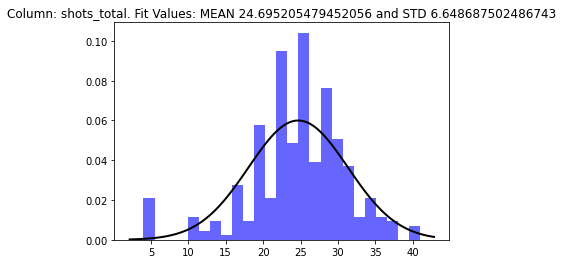

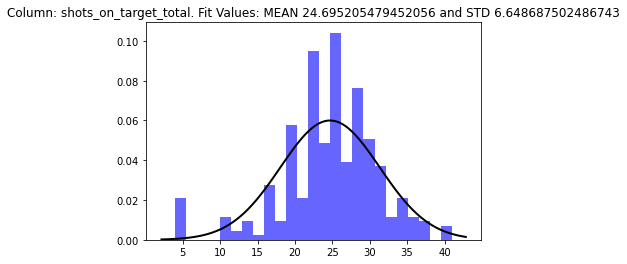

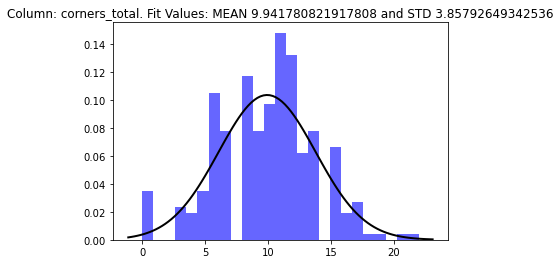

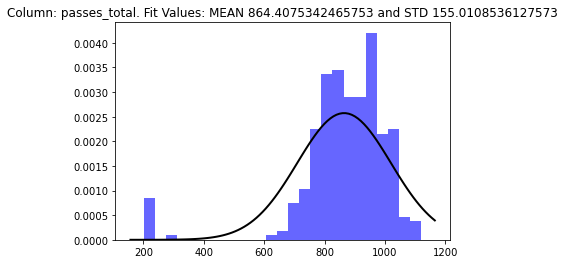

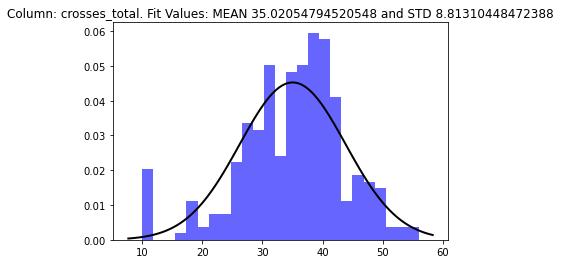

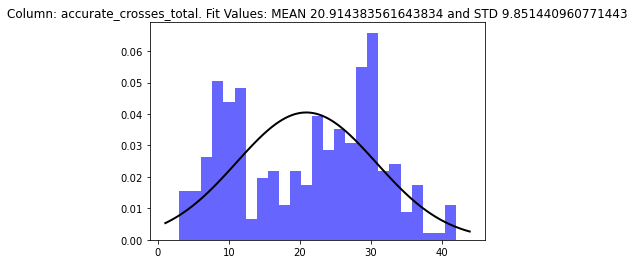

In [49]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

for col in cols_to_check_normality:
    fit_and_draw_normal(data_f[col], col)

### Where it comes to passes_total (and similarly: corners_total, crosses_total), matches with passes "< 250" seems really weird to me (typical match should have more passes according to my knowledge)

In [35]:
data_f[data_f['passes_total'] < 300]

,team_1st,team_2nd,score_1st,score_2nd,possession_1st,possession_2nd,shots_1st,shots_2nd,shots_on_target_1st,shots_on_target_2nd,...,shots_on_target_total,corners_total,fouls_total,passes_total,accurate_passes_total,crosses_total,accurate_crosses_total,successful_tackles_total,offsides_total,yellow_cards_total
90,PGE FKS STAL MIELEC,JAGIELLONIA BIAŁYSTOK,1,1,61.0,39.0,0.0,4.0,0.0,2.0,...,4.0,0.0,2.0,203.0,170.0,10.0,10.0,0.0,0.0,NaN
91,POGOŃ SZCZECIN,RADOMIAK RADOM,4,0,61.0,39.0,0.0,4.0,0.0,2.0,...,4.0,0.0,2.0,203.0,170.0,10.0,10.0,0.0,0.0,NaN
92,BRUK-BET TERMALICA NIECIECZA,WARTA POZNAŃ,1,0,61.0,39.0,0.0,4.0,0.0,2.0,...,4.0,0.0,2.0,203.0,170.0,10.0,10.0,0.0,0.0,NaN
93,KGHM ZAGŁĘBIE LUBIN,PIAST GLIWICE,0,0,61.0,39.0,0.0,4.0,0.0,2.0,...,4.0,0.0,2.0,203.0,170.0,10.0,10.0,0.0,0.0,NaN
94,LECHIA GDAŃSK,WISŁA KRAKÓW,1,1,61.0,39.0,0.0,4.0,0.0,2.0,...,4.0,0.0,2.0,203.0,170.0,10.0,10.0,0.0,0.0,NaN
95,WISŁA PŁOCK,GÓRNIK ŁĘCZNA,3,1,61.0,39.0,0.0,4.0,0.0,2.0,...,4.0,0.0,2.0,203.0,170.0,10.0,10.0,0.0,0.0,NaN
96,GÓRNIK ZABRZE,CRACOVIA,3,0,61.0,39.0,0.0,4.0,0.0,2.0,...,4.0,0.0,2.0,203.0,170.0,10.0,10.0,0.0,0.0,NaN
97,LECH POZNAŃ,RAKÓW CZĘSTOCHOWA,0,1,61.0,39.0,0.0,4.0,0.0,2.0,...,4.0,0.0,2.0,203.0,170.0,10.0,10.0,0.0,0.0,NaN
98,LEGIA WARSZAWA,ŚLĄSK WROCŁAW,1,0,61.0,39.0,0.0,4.0,0.0,2.0,...,4.0,0.0,2.0,203.0,170.0,10.0,10.0,0.0,0.0,NaN


### As we can see above: something have probably gone wrong during data scrapping, because i dont believe many matches would have the same statistics

ShapiroResult(statistic=0.9645153880119324, pvalue=1.97407075575029e-06)
ShapiroResult(statistic=0.9905837774276733, pvalue=0.06666072458028793)


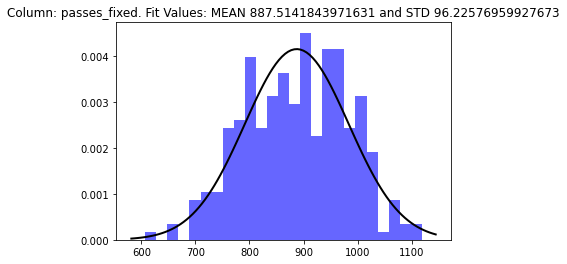

In [54]:
passes_fixed_300 = data_f[data_f['passes_total'] > 300]['passes_total']
passes_fixed_400 = data_f[data_f['passes_total'] > 400]['passes_total']
print(shapiro(passes_fixed_300))
print(shapiro(passes_fixed_400))
fit_and_draw_normal(passes_fixed_400, 'passes_fixed')

### The test result is not so convincing but at least the histogram looks more like a normal